# Packages

In [1]:
# ==========================================
# Chargement
# ==========================================
import os
import pickle
import joblib
import numpy as np
import pandas as pd

# ---------- Helpers ----------
def load_any(path):
    """Charge un objet avec joblib puis pickle si besoin."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable: {path}")
    try:
        return joblib.load(path)
    except Exception:
        with open(path, "rb") as f:
            return pickle.load(f)

def try_read_meta(path):
    """Lit un CSV méta (Series si 1 colonne, sinon DataFrame)."""
    try:
        meta = pd.read_csv(path, index_col=0)
        if meta.shape[1] == 1:
            meta = meta.iloc[:, 0]  # Series
        return meta
    except Exception as e:
        print(f"⚠️ Impossible de lire {path} : {e}")
        return None

def safe_meta_print(meta, keys):
    """Affiche les clés demandées sans lever d'erreur si elles manquent."""
    if meta is None:
        print("⚠️ Pas de méta disponible.")
        return
    # Convertit en dict pour accès uniforme
    if isinstance(meta, pd.Series):
        d = meta.to_dict()
    elif isinstance(meta, pd.DataFrame):
        # prend la 1ère ligne si DataFrame
        d = meta.iloc[0].to_dict()
    elif isinstance(meta, dict):
        d = meta
    else:
        print(f"(info) Type de méta inattendu: {type(meta)}")
        d = {}

    print("\n--- Métadonnées AR(1) (clé: valeur) ---")
    for k in keys:
        v = d.get(k, None)
        print(f"{k}: {v}")

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

In [2]:
# ---------- Fichiers ----------
AR1_LAST_PKL  = "AR1_last_trained_model.pkl"
AR1_LAST_META = "AR1_last_trained_model_meta.csv"
AR1_BUNDLE    = "AR1_h12_oos_bundle.pkl"

LINREG_PKL    = "linear_regression.pkl"
LINREG_META   = "linear_regression_meta.csv"

# 🔹 AR(p)
ARP_LAST_PKL  = "ARP_last_trained_model.pkl"
ARP_LAST_META = "ARP_last_trained_model_meta.csv"
ARP_BUNDLE    = "ARP_h12_oos_bundle.pkl"

# 🔹 LightGBM
LGBM_PKL       = "lightgbm_regression.pkl"
LGBM_META      = "lightgbm_regression_meta.csv"
LGBM_LAST_PKL  = "LGBM_last_trained_model.pkl"
LGBM_LAST_META = "LGBM_last_trained_model_meta.csv"

# 🔹 Ridge
RIDGE_LAST_PKL  = "RIDGE_last_trained_model.pkl"
RIDGE_LAST_META = "RIDGE_last_trained_model_meta.csv"
RIDGE_BUNDLE    = "ridge_regression.pkl"
RIDGE_META      = "ridge_regression_meta.csv"

# 🔹 VECM
VECM_PKL       = "vecm_oos.pkl"                      # bundle OOS (date,y_pred,y_true + meta)
VECM_META      = "vecm_oos_meta.csv"                 # méta du bundle OOS
VECM_LAST_PKL  = "VECM_last_trained_model.pkl"       # artefact "dernier modèle" (params du dernier fit)
VECM_LAST_META = "VECM_last_trained_model_meta.csv"  # méta du dernier fit

In [3]:
# ============= CHARGEMENTS COMPLETS =============

print("=== Chargement AR(1) ===")
try:
    ar1_model = load_any(AR1_LAST_PKL)
    print("✅ Modèle AR(1) chargé.")
except Exception as e:
    ar1_model = None
    print(f"⚠️ Modèle AR(1) non chargé : {e}")
ar1_meta  = try_read_meta(AR1_LAST_META)

try:
    ar1_bundle = load_any(AR1_BUNDLE)
    print("✅ Bundle AR(1) chargé (OOS h=12).")
except Exception as e:
    ar1_bundle = None
    print(f"⚠️ Bundle AR(1) non chargé : {e}")

print("\n=== Chargement AR(p) ===")
try:
    arp_model = load_any(ARP_LAST_PKL)
    print("✅ Modèle AR(p) chargé.")
except Exception as e:
    arp_model = None
    print(f"⚠️ Modèle AR(p) non chargé : {e}")
arp_meta = try_read_meta(ARP_LAST_META)

try:
    arp_bundle = load_any(ARP_BUNDLE)
    print("✅ Bundle AR(p) chargé (OOS h=12).")
except Exception as e:
    arp_bundle = None
    print(f"⚠️ Bundle AR(p) non chargé : {e}")

print("\n=== Chargement Régression Linéaire ===")
try:
    linreg_bundle = load_any(LINREG_PKL)   # dict avec 'oos_predictions', 'params', etc.
    print("✅ Régression linéaire chargée.")
except Exception as e:
    linreg_bundle = None
    print(f"⚠️ Régression linéaire non chargée : {e}")
linreg_meta = try_read_meta(LINREG_META)

print("\n=== Chargement LightGBM ===")
try:
    lgbm_model_last = load_any(LGBM_LAST_PKL)   # ensemble (bagging) du dernier fit
    print("✅ Dernier ensemble LightGBM chargé.")
except Exception as e:
    lgbm_model_last = None
    print(f"⚠️ Dernier ensemble LightGBM non chargé : {e}")
lgbm_last_meta = try_read_meta(LGBM_LAST_META)

try:
    lgbm_bundle = load_any(LGBM_PKL)            # bundle OOS (date,y_pred,y_true + params)
    print("✅ Bundle LightGBM chargé (OOS h=12).")
except Exception as e:
    lgbm_bundle = None
    print(f"⚠️ Bundle LightGBM non chargé : {e}")
lgbm_meta = try_read_meta(LGBM_META)

print("\n=== Chargement Ridge ===")
try:
    ridge_model_last = load_any(RIDGE_LAST_PKL)  # dernier modèle (ou ensemble) + préproc
    print("✅ Dernier modèle Ridge chargé.")
except Exception as e:
    ridge_model_last = None
    print(f"⚠️ Dernier modèle Ridge non chargé : {e}")
ridge_last_meta = try_read_meta(RIDGE_LAST_META)

try:
    ridge_bundle = load_any(RIDGE_BUNDLE)        # bundle OOS (date,y_pred,y_true + params)
    print("✅ Bundle Ridge chargé (OOS h=12).")
except Exception as e:
    ridge_bundle = None
    print(f"⚠️ Bundle Ridge non chargé : {e}")
ridge_meta = try_read_meta(RIDGE_META)

print("\n=== Chargement VECM ===")
try:
    vecm_model_last = load_any(VECM_LAST_PKL)    # artefact dernier fit (params, etc.)
    print("✅ Dernier modèle VECM chargé.")
except Exception as e:
    vecm_model_last = None
    print(f"⚠️ Dernier modèle VECM non chargé : {e}")
vecm_last_meta = try_read_meta(VECM_LAST_META)

try:
    vecm_bundle = load_any(VECM_PKL)             # bundle OOS (date,y_pred,y_true + meta)
    print("✅ Bundle VECM chargé (OOS h=12).")
except Exception as e:
    vecm_bundle = None
    print(f"⚠️ Bundle VECM non chargé : {e}")
vecm_meta = try_read_meta(VECM_META)

# --------- (Optionnel) petits aperçus ---------
def _peek_meta(name, meta, cols_pref):
    if isinstance(meta, pd.Series):
        meta = meta.to_frame().T
    if isinstance(meta, pd.DataFrame):
        cols = [c for c in cols_pref if c in meta.columns]
        if cols:
            print(f"\n--- Métadonnées {name} ---")
            print(meta[cols].head(3))
        else:
            print(f"\n--- Métadonnées {name} (colonnes brutes) ---")
            print(meta.head(3))

_peek_meta("AR(p)", arp_meta, ["model","p_used_last","trained_until","aic","bic",
                               "MAE_1983_89","RMSE_1983_89","R2_1983_89"])
_peek_meta("AR(1)", ar1_meta, ["model","trained_until","aic","bic",
                               "mae_83_89","rmse_83_89","r2_83_89"])
_peek_meta("LinearRegression", linreg_meta, ["model","horizon","winsor_level","norm_var",
                                             "trained_until","n_forecasts"])
_peek_meta("LightGBM", lgbm_meta, ["model","n_boot","random_search_iterations",
                                   "refit_every_months","retune_every_months"])
_peek_meta("Ridge", ridge_meta, ["model","n_boot","refit_every_months","retune_every_months",
                                 "winsor_level","norm_var","trained_until","n_forecasts"])
_peek_meta("VECM", vecm_meta, ["model","horizon","min_train_n","winsor_level",
                               "refit_every_months","retune_every_months",
                               "p_max","rank_max","det_set",
                               "trained_until","n_forecasts"])

=== Chargement AR(1) ===
✅ Modèle AR(1) chargé.
✅ Bundle AR(1) chargé (OOS h=12).

=== Chargement AR(p) ===
✅ Modèle AR(p) chargé.
✅ Bundle AR(p) chargé (OOS h=12).

=== Chargement Régression Linéaire ===
✅ Régression linéaire chargée.

=== Chargement LightGBM ===
✅ Dernier ensemble LightGBM chargé.
✅ Bundle LightGBM chargé (OOS h=12).

=== Chargement Ridge ===
✅ Dernier modèle Ridge chargé.
✅ Bundle Ridge chargé (OOS h=12).

=== Chargement VECM ===
✅ Dernier modèle VECM chargé.
✅ Bundle VECM chargé (OOS h=12).

--- Métadonnées AR(p) ---
   model  p_used_last trained_until
0  AR(p)            4    2024-08-01

--- Métadonnées AR(1) ---
   model trained_until
0  AR(1)    2024-08-01

--- Métadonnées LinearRegression ---
              model  horizon  winsor_level  norm_var trained_until  \
0  LinearRegression       12          0.01      True    2024-08-01   

   n_forecasts  
0          741  

--- Métadonnées LightGBM ---
                  n_boot  refit_every_months  retune_every_months
mo

In [4]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

# ========= utilitaires =========
def _get(meta, key, default=None):
    if meta is None:
        return default
    if isinstance(meta, dict):
        return meta.get(key, default)
    if isinstance(meta, pd.Series):
        return meta.get(key, default)
    if isinstance(meta, pd.DataFrame) and key in meta.columns:
        return meta[key].iloc[0]
    return default

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

# ========= AR générique -> DataFrame =========
def build_df_ar(ar_bundle=None, ar1_meta=None):
    # 1) Bundle dispo
    if ar_bundle is not None and isinstance(ar_bundle, dict) and "oos_predictions" in ar_bundle:
        df = ar_bundle["oos_predictions"].copy()
        if df.index.name is not None:
            df = df.reset_index()

        cols = {c.lower(): c for c in df.columns}
        date_col = cols.get("date") or cols.get("dates")
        true_col = cols.get("y_true") or cols.get("true")
        pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
        assert date_col and true_col and pred_col, f"Colonnes manquantes: {df.columns.tolist()}"

        out = df[[date_col, true_col, pred_col]].rename(columns={date_col:"date", true_col:"true", pred_col:"pred"})
        out["date"] = _normalize_month_start(out["date"])

        method_name = _get(ar_bundle.get("params", {}), "model", "AR")
        lag = _get(ar_bundle.get("params", {}), "lag", _get(ar_bundle.get("params", {}), "order_p", None))
        out["method"]      = method_name
        out["hyper_type"]  = _get(ar_bundle.get("params", {}), "hyper_type", "expanding_oos")
        out["features"]    = _get(ar_bundle, "features", 1)
        out["lag"]         = lag
        out["n_boot"]      = _get(ar_bundle.get("params", {}), "n_boot", None)
        out["winsorize"]   = _get(ar_bundle.get("params", {}), "winsor_level", None)
        out["window_size"] = _get(ar_bundle.get("params", {}), "window_size", None)

        out = out.reset_index(drop=True)
        print(f"✅ df_{method_name} prêt — from bundle — shape={out.shape}")
        return out

    # 2) Fallback calcul OOS si série univariée dispo
    eval_start = pd.to_datetime(_get(ar1_meta, "eval_start", "1983-01-01"))
    eval_end   = pd.to_datetime(_get(ar1_meta, "eval_end",   "1989-12-31"))
    h          = int(_get(ar1_meta, "horizon", 12))
    min_train_n= int(_get(ar1_meta, "min_train_n", 36))
    p_used     = int(_get(ar1_meta, "order_p", _get(ar1_meta, "p_used", 1)))

    if "df_stationary_train_unrate" in globals():
        from statsmodels.tsa.ar_model import AutoReg
        y = globals()["df_stationary_train_unrate"].squeeze().sort_index().astype(float).dropna()
        y.index = pd.to_datetime(y.index).to_period("M").to_timestamp(how="start")
        y = y.asfreq("MS")

        rows = []
        last_t_end = y.index.max() - relativedelta(months=h)
        for t_end in y.index:
            if t_end > last_t_end:
                break
            y_tr = y.loc[:t_end]
            if len(y_tr) < min_train_n:
                continue
            ar = AutoReg(y_tr, lags=p_used, old_names=False).fit()
            fc = ar.predict(start=len(y_tr), end=len(y_tr) + h - 1)
            yhat_h = float(fc.iloc[-1])
            t_fore = t_end + relativedelta(months=h)
            if t_fore in y.index:
                rows.append((t_fore, float(y.loc[t_fore]), yhat_h))

        out = pd.DataFrame(rows, columns=["date", "true", "pred"]).sort_values("date")
        out["date"] = _normalize_month_start(out["date"])
        out = out[(out["date"] >= eval_start) & (out["date"] <= eval_end)].copy()

        out["method"]      = f"AR({p_used})"
        out["hyper_type"]  = "expanding_oos"
        out["features"]    = 1
        out["lag"]         = p_used
        out["n_boot"]      = None
        out["winsorize"]   = None
        out["window_size"] = None

        out = out.reset_index(drop=True)
        print(f"✅ df_AR({p_used}) prêt — OOS h={h} (expanding) — shape={out.shape}")
        return out

    # 3) Rien
    raise RuntimeError(
        "Impossible de construire df_ar: fournis un bundle AR (AR1/ARP) ou 'df_stationary_train_unrate'."
    )

# ========= LinearRegression -> df_lin =========
def build_df_lin(linreg_bundle):
    if linreg_bundle is None or "oos_predictions" not in linreg_bundle:
        print("⚠️ linreg_bundle absent ou invalide.")
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = linreg_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans oos_predictions: {oos.columns.tolist()}"

    out = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    out["date"] = _normalize_month_start(out["date"])

    params = linreg_bundle.get("params", {}) or {}
    features = linreg_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    out["method"]      = params.get("model", "LinearRegression")
    out["hyper_type"]  = params.get("hyper_type", "kfold_block_gap")
    out["features"]    = features
    out["lag"]         = params.get("shift_lag", params.get("lag", None))
    out["n_boot"]      = params.get("n_boot", None)
    out["winsorize"]   = params.get("winsor_level", params.get("winsorize", None))
    out["window_size"] = params.get("window_size", None)

    out = out.reset_index(drop=True)
    print(f"✅ df_lin prêt — from oos_predictions — shape={out.shape}")
    return out

# ========= Ridge -> df_ridge =========
def build_df_ridge(ridge_bundle):
    if ridge_bundle is None or "oos_predictions" not in ridge_bundle:
        print("⚠️ ridge_bundle absent ou invalide.")
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = ridge_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans ridge oos_predictions: {oos.columns.tolist()}"

    out = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    out["date"] = _normalize_month_start(out["date"])

    params = ridge_bundle.get("params", {}) or {}
    features = ridge_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    out["method"]      = params.get("model", "Ridge")
    out["hyper_type"]  = params.get("alpha_schedule", "hv-block CV (gap=12)")
    out["features"]    = features
    out["lag"]         = params.get("lag", None)
    out["n_boot"]      = params.get("n_boot", None)
    out["winsorize"]   = params.get("winsor_level", None)
    out["window_size"] = params.get("window_size", None)

    out = out.reset_index(drop=True)
    print(f"✅ df_ridge prêt — from oos_predictions — shape={out.shape}")
    return out

# ========= LightGBM -> df_lgbm =========
def build_df_lgbm(lgbm_bundle):
    if lgbm_bundle is None or "oos_predictions" not in lgbm_bundle:
        print("⚠️ lgbm_bundle absent ou invalide.")
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = lgbm_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans lgbm oos_predictions: {oos.columns.tolist()}"

    out = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    out["date"] = _normalize_month_start(out["date"])

    params = lgbm_bundle.get("params", {}) or {}
    features = lgbm_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    out["method"]      = params.get("model", "LightGBM")
    out["hyper_type"]  = params.get("hyper_type", "kfold_block_gap + random search")
    out["features"]    = features
    out["lag"]         = params.get("lag", 12)
    out["n_boot"]      = params.get("n_boot", 30)
    out["winsorize"]   = params.get("winsor_level", None)
    out["window_size"] = params.get("window_size", None)

    out = out.reset_index(drop=True)
    print(f"✅ df_lgbm prêt — from oos_predictions — shape={out.shape}")
    return out

# ========= VECM -> df_vecm =========
def build_df_vecm(vecm_bundle):
    """
    Bundle VECM produit par notre script (VECM_BUNDLE):
      - 'oos_predictions': DataFrame avec colonnes ['date','y_pred','y_true'] (ou variantes)
      - 'params': dict avec 'model' etc.
    """
    if vecm_bundle is None or "oos_predictions" not in vecm_bundle:
        print("⚠️ vecm_bundle absent ou invalide.")
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = vecm_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and pred_col, f"Colonnes manquantes dans vecm oos_predictions: {oos.columns.tolist()}"

    # s'il n'y a pas y_true dans le bundle, on le met à NaN
    out = oos[[date_col, pred_col] + ([true_col] if true_col else [])].copy()
    out = out.rename(columns={date_col: "date", pred_col: "pred", (true_col or "y_true"): "true"})
    out["date"] = _normalize_month_start(out["date"])

    params = vecm_bundle.get("params", {}) or {}
    out["method"]      = params.get("model", "VECM")
    out["hyper_type"]  = "MAE rolling-origin (p, rank, det)"
    out["features"]    = len(params.get("features", [])) if isinstance(params.get("features", []), list) else None
    out["lag"]         = None
    out["n_boot"]      = None
    out["winsorize"]   = params.get("winsor_level", None)
    out["window_size"] = None

    out = out.reset_index(drop=True)
    print(f"✅ df_vecm prêt — from oos_predictions — shape={out.shape}")
    return out

# ======= Construction depuis les bundles chargés en amont =======
dfs = []

# AR(1)
if "ar1_bundle" in globals() and isinstance(ar1_bundle, dict):
    try:
        df_ar1 = build_df_ar(ar_bundle=ar1_bundle, ar1_meta=globals().get("ar1_meta", None))
        if not df_ar1.empty:
            dfs.append(df_ar1)
    except Exception as e:
        print(f"⚠️ build_df_ar (AR1) a échoué : {e}")

# AR(p)
if "arp_bundle" in globals() and isinstance(arp_bundle, dict):
    try:
        df_arp = build_df_ar(ar_bundle=arp_bundle, ar1_meta=globals().get("arp_meta", None))
        if not df_arp.empty:
            dfs.append(df_arp)
    except Exception as e:
        print(f"⚠️ build_df_ar (AR(p)) a échoué : {e}")

# LinearRegression
if "linreg_bundle" in globals() and isinstance(linreg_bundle, dict):
    try:
        df_lin = build_df_lin(linreg_bundle)
        if not df_lin.empty:
            dfs.append(df_lin)
    except Exception as e:
        print(f"⚠️ build_df_lin a échoué : {e}")

# Ridge
if "ridge_bundle" in globals() and isinstance(ridge_bundle, dict):
    try:
        df_ridge = build_df_ridge(ridge_bundle)
        if not df_ridge.empty:
            dfs.append(df_ridge)
    except Exception as e:
        print(f"⚠️ build_df_ridge a échoué : {e}")

# LightGBM
if "lgbm_bundle" in globals() and isinstance(lgbm_bundle, dict):
    try:
        df_lgbm = build_df_lgbm(lgbm_bundle)
        if not df_lgbm.empty:
            dfs.append(df_lgbm)
    except Exception as e:
        print(f"⚠️ build_df_lgbm a échoué : {e}")

# VECM
if "vecm_bundle" in globals() and isinstance(vecm_bundle, dict):
    try:
        df_vecm = build_df_vecm(vecm_bundle)
        if not df_vecm.empty:
            dfs.append(df_vecm)
    except Exception as e:
        print(f"⚠️ build_df_vecm a échoué : {e}")

# ======= Fusion finale =======
if len(dfs) == 0:
    raise RuntimeError("Aucun bundle exploitable (AR1, AR(p), LinearRegression, Ridge, LightGBM, VECM).")

df_pred_long = pd.concat(dfs, ignore_index=True)

# Nettoyage colonnes techniques (optionnel pour plotting simple)
cols_to_drop = ["hyper_type", "features", "lag", "n_boot", "winsorize", "window_size"]
df_pred_long = df_pred_long.drop(columns=[c for c in cols_to_drop if c in df_pred_long.columns], errors="ignore")

# Tri & index propre
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"], errors="coerce")
df_pred_long = df_pred_long.dropna(subset=["date", "true", "pred"]).sort_values(["date", "method"]).reset_index(drop=True)

print(f"\n✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
print("Colonnes :", df_pred_long.columns.tolist())
print("Méthodes :", sorted(df_pred_long["method"].unique().tolist()))

print("\nAperçu des premières lignes :")
print(df_pred_long.head(10))

✅ df_AR(1) prêt — from bundle — shape=(741, 10)
✅ df_AR(p) prêt — from bundle — shape=(741, 10)
✅ df_lin prêt — from oos_predictions — shape=(741, 10)
✅ df_ridge prêt — from oos_predictions — shape=(741, 10)
✅ df_lgbm prêt — from oos_predictions — shape=(741, 10)
✅ df_vecm prêt — from oos_predictions — shape=(729, 10)

✅ Fusion réussie — df_pred_long shape = (4434, 4)
Colonnes : ['date', 'true', 'pred', 'method']
Méthodes : ['AR(1)', 'AR(p)', 'LightGBM + Bagging', 'LinearRegression', 'Ridge + Bagging', 'VECM (MAE-tuned)']

Aperçu des premières lignes :
        date  true      pred              method
0 1963-12-01   0.0 -0.080890               AR(1)
1 1963-12-01   0.0 -0.080890               AR(p)
2 1963-12-01   0.0  0.097778  LightGBM + Bagging
3 1963-12-01   0.0 -0.354113    LinearRegression
4 1963-12-01   0.0 -0.254922     Ridge + Bagging
5 1964-01-01  -0.1  0.141077               AR(1)
6 1964-01-01  -0.1  0.141077               AR(p)
7 1964-01-01  -0.1  0.097778  LightGBM + Bagging


C:\Users\Mita\AppData\Local\Temp\ipykernel_13068\1706534752.py:313: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pred_long = pd.concat(dfs, ignore_index=True)


In [5]:
import numpy as np
import pandas as pd

# ========= utilitaires =========
def _get(meta, key, default=None):
    if meta is None:
        return default
    if isinstance(meta, dict):
        return meta.get(key, default)
    if isinstance(meta, pd.Series):
        return meta.get(key, default)
    if isinstance(meta, pd.DataFrame) and key in meta.columns:
        return meta[key].iloc[0]
    return default

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

# ========= AR générique (AR(p) / AR(1)) =========
def build_df_from_ar_bundle(ar_bundle, fallback_name="AR"):
    if ar_bundle is None or "oos_predictions" not in ar_bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])

    df = ar_bundle["oos_predictions"].copy()
    if df.index.name is not None:
        df = df.reset_index()

    cols = {c.lower(): c for c in df.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes: {df.columns.tolist()}"

    out = df[[date_col, true_col, pred_col]].rename(columns={date_col:"date", true_col:"true", pred_col:"pred"})
    out["date"] = _normalize_month_start(out["date"])

    method_name = _get(ar_bundle.get("params", {}), "model", fallback_name)
    out["method"] = method_name

    if "p_used" in df.columns:
        out["p_used"] = df["p_used"].values

    out["hyper_type"]  = _get(ar_bundle.get("params", {}), "hyper_type", "expanding_oos")
    out["features"]    = _get(ar_bundle, "features", 1)
    out["lag"]         = _get(ar_bundle.get("params", {}), "lag", _get(ar_bundle.get("params", {}), "order_p", None))
    out["n_boot"]      = _get(ar_bundle.get("params", {}), "n_boot", None)
    out["winsorize"]   = _get(ar_bundle.get("params", {}), "winsorize", _get(ar_bundle.get("params", {}), "winsor_level", None))
    out["window_size"] = _get(ar_bundle.get("params", {}), "window_size", None)

    out = out.reset_index(drop=True)
    print(f"✅ df_{method_name} prêt — from bundle — shape={out.shape}")
    return out

# ========= LinearRegression -> df_lin =========
def build_df_lin(linreg_bundle):
    if linreg_bundle is None or "oos_predictions" not in linreg_bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = linreg_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans oos_predictions: {oos.columns.tolist()}"

    df = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    df["date"] = _normalize_month_start(df["date"])

    params = linreg_bundle.get("params", {}) or {}
    features = linreg_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    df["method"]      = params.get("model", "LinearRegression")
    df["hyper_type"]  = params.get("hyper_type", "kfold_block_gap")
    df["features"]    = features
    df["lag"]         = params.get("shift_lag", params.get("lag", None))
    df["n_boot"]      = params.get("n_boot", None)
    df["winsorize"]   = params.get("winsor_level", params.get("winsorize", None))
    df["window_size"] = params.get("window_size", None)

    df = df.reset_index(drop=True)
    print(f"✅ df_lin prêt — from oos_predictions — shape={df.shape}")
    return df

# ========= Ridge -> df_ridge =========
def build_df_ridge(ridge_bundle):
    if ridge_bundle is None or "oos_predictions" not in ridge_bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = ridge_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans oos_predictions: {oos.columns.tolist()}"

    df = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    df["date"] = _normalize_month_start(df["date"])

    params = ridge_bundle.get("params", {}) or {}
    meta   = ridge_bundle.get("meta",   {}) or {}

    features = params.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    df["method"]      = params.get("model", "Ridge")
    df["hyper_type"]  = params.get("alpha_schedule", "hv-block CV (gap=12)")
    df["features"]    = features
    df["lag"]         = params.get("lag", None)
    df["n_boot"]      = params.get("n_boot", _get(meta, "n_boot", None))
    df["winsorize"]   = params.get("winsor_level", params.get("winsorize", None))
    df["window_size"] = params.get("window_size", None)

    alpha_hist = _get(meta, "alpha_history", None)
    df["alpha_last"] = float(alpha_hist[-1]) if isinstance(alpha_hist, (list, tuple)) and len(alpha_hist) else None

    if "y_pred_std" in oos.columns:
        df["pred_std"] = oos["y_pred_std"].values

    df = df.reset_index(drop=True)
    print(f"✅ df_ridge prêt — from oos_predictions — shape={df.shape}")
    return df

# ========= LightGBM -> df_lgbm =========
def build_df_lgbm(lgbm_bundle):
    if lgbm_bundle is None or "oos_predictions" not in lgbm_bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = lgbm_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans lgbm oos_predictions: {oos.columns.tolist()}"

    df = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    df["date"] = _normalize_month_start(df["date"])

    params = lgbm_bundle.get("params", {}) or {}
    features = lgbm_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    df["method"]      = params.get("model", "LightGBM")
    df["hyper_type"]  = params.get("hyper_type", "kfold_block_gap + random search")
    df["features"]    = features
    df["lag"]         = params.get("lag", 12)
    df["n_boot"]      = params.get("n_boot", 30)
    df["winsorize"]   = params.get("winsor_level", None)
    df["window_size"] = params.get("window_size", None)

    df = df.reset_index(drop=True)
    print(f"✅ df_lgbm prêt — from oos_predictions — shape={df.shape}")
    return df

# ========= VECM -> df_vecm =========
def build_df_vecm(vecm_bundle):
    """
    Bundle VECM attendu: {'oos_predictions': DataFrame(date, y_pred, y_true), 'params': {...}}
    """
    if vecm_bundle is None or "oos_predictions" not in vecm_bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = vecm_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    true_col = cols.get("y_true") or cols.get("true")  # peut être absent selon le bundle
    assert date_col and pred_col, f"Colonnes manquantes dans vecm oos_predictions: {oos.columns.tolist()}"

    if true_col:
        df = oos[[date_col, true_col, pred_col]].rename(columns={date_col:"date", true_col:"true", pred_col:"pred"})
    else:
        df = oos[[date_col, pred_col]].rename(columns={date_col:"date", pred_col:"pred"})
        df["true"] = np.nan

    df["date"] = _normalize_month_start(df["date"])

    params = vecm_bundle.get("params", {}) or {}
    feats = params.get("features", [])
    df["method"]      = params.get("model", "VECM")
    df["hyper_type"]  = "MAE rolling-origin (p, rank, det)"
    df["features"]    = len(feats) if isinstance(feats, list) else None
    df["lag"]         = None
    df["n_boot"]      = None
    df["winsorize"]   = params.get("winsor_level", None)
    df["window_size"] = None

    df = df.reset_index(drop=True)
    print(f"✅ df_vecm prêt — from oos_predictions — shape={df.shape}")
    return df

# ======= Construction des DF =======
dfs = []

# AR(p)
if "arp_bundle" in globals():
    df_arp = build_df_from_ar_bundle(arp_bundle, fallback_name="AR(p)")
    if not df_arp.empty:
        dfs.append(df_arp)

# AR(1)
if "ar1_bundle" in globals():
    df_ar1 = build_df_from_ar_bundle(ar1_bundle, fallback_name="AR(1)")
    if not df_ar1.empty:
        dfs.append(df_ar1)

# LinearRegression
if "linreg_bundle" in globals():
    df_lin = build_df_lin(linreg_bundle)
    if not df_lin.empty:
        dfs.append(df_lin)

# Ridge
if "ridge_bundle" in globals():
    df_ridge = build_df_ridge(ridge_bundle)
    if not df_ridge.empty:
        dfs.append(df_ridge)

# LightGBM
if "lgbm_bundle" in globals():
    df_lgbm = build_df_lgbm(lgbm_bundle)
    if not df_lgbm.empty:
        dfs.append(df_lgbm)

# VECM
if "vecm_bundle" in globals():
    df_vecm = build_df_vecm(vecm_bundle)
    if not df_vecm.empty:
        dfs.append(df_vecm)

if len(dfs) == 0:
    raise RuntimeError("Aucun bundle exploitable (arp, ar1, linreg, ridge, lgbm, vecm).")

# ======= Fusion finale =======
df_pred_long = pd.concat(dfs, ignore_index=True)

# Nettoyage colonnes non essentielles pour plots simples
cols_to_drop = ["hyper_type", "features", "lag", "n_boot", "winsorize", "window_size"]
df_pred_long = df_pred_long.drop(columns=[c for c in cols_to_drop if c in df_pred_long.columns], errors="ignore")

# Tri & index propre
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"], errors="coerce")
df_pred_long = df_pred_long.dropna(subset=["date", "true", "pred"]).sort_values(["date", "method"]).reset_index(drop=True)

print(f"\n✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
print("Colonnes :", df_pred_long.columns.tolist())
print("Méthodes :", sorted(df_pred_long["method"].unique().tolist()))
print("\nAperçu des premières lignes :")
print(df_pred_long.head(10))

✅ df_AR(p) prêt — from bundle — shape=(741, 11)
✅ df_AR(1) prêt — from bundle — shape=(741, 10)
✅ df_lin prêt — from oos_predictions — shape=(741, 10)
✅ df_ridge prêt — from oos_predictions — shape=(741, 12)
✅ df_lgbm prêt — from oos_predictions — shape=(741, 10)
✅ df_vecm prêt — from oos_predictions — shape=(729, 10)

✅ Fusion réussie — df_pred_long shape = (4434, 7)
Colonnes : ['date', 'true', 'pred', 'method', 'p_used', 'alpha_last', 'pred_std']
Méthodes : ['AR(1)', 'AR(p)', 'LightGBM + Bagging', 'LinearRegression', 'Ridge + Bagging', 'VECM (MAE-tuned)']

Aperçu des premières lignes :
        date  true      pred              method  p_used  alpha_last  pred_std
0 1963-12-01   0.0 -0.080890               AR(1)     NaN         NaN       NaN
1 1963-12-01   0.0 -0.080890               AR(p)     1.0         NaN       NaN
2 1963-12-01   0.0  0.097778  LightGBM + Bagging     NaN         NaN       NaN
3 1963-12-01   0.0 -0.354113    LinearRegression     NaN         NaN       NaN
4 1963-12-

C:\Users\Mita\AppData\Local\Temp\ipykernel_13068\3001031883.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pred_long = pd.concat(dfs, ignore_index=True)


In [6]:
# ==========================================
# 🔹 Fusion AR(p) + AR(1) + LinearRegression + Ridge + LightGBM + VECM
# ==========================================

dfs = []
candidates = [
    ("AR(p)", df_arp)            if "df_arp"   in globals() else None,
    ("AR(1)", df_ar1)            if "df_ar1"   in globals() else None,
    ("LinearRegression", df_lin) if "df_lin"   in globals() else None,
    ("Ridge", df_ridge)          if "df_ridge" in globals() else None,
    ("LightGBM", df_lgbm)        if "df_lgbm"  in globals() else None,
    ("VECM", df_vecm)            if "df_vecm"  in globals() else None,
]
for name_df in filter(None, candidates):
    name, d = name_df
    if isinstance(d, pd.DataFrame) and not d.empty:
        dfs.append(d)
    else:
        print(f"⚠️ {name} absent ou vide — ignoré.")

if len(dfs) == 0:
    raise RuntimeError("Aucun DataFrame dispo (df_arp, df_ar1, df_lin, df_ridge, df_lgbm, df_vecm).")

# Concaténation verticale
df_pred_long = pd.concat(dfs, ignore_index=True)

# Dates propres + tri + nettoyage
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"], errors="coerce")
df_pred_long = (
    df_pred_long
    .dropna(subset=["date", "true", "pred"])
    .sort_values(["date", "method"])
    .reset_index(drop=True)
)

# Colonnes techniques optionnelles à retirer (si présentes)
cols_to_drop = ["hyper_type", "features", "lag", "n_boot", "winsorize", "window_size"]
df_pred_long = df_pred_long.drop(columns=[c for c in cols_to_drop if c in df_pred_long.columns], errors="ignore")

# Petits diagnostics
print(f"✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
print("Période couverte :", df_pred_long["date"].min().date(), "→", df_pred_long["date"].max().date())
print("\nMéthodes présentes :")
print(df_pred_long["method"].value_counts().sort_index())
print("\nAperçu df_pred_long :")
print(df_pred_long.head(10))

✅ Fusion réussie — df_pred_long shape = (4434, 7)
Période couverte : 1963-12-01 → 2025-08-01

Méthodes présentes :
method
AR(1)                 741
AR(p)                 741
LightGBM + Bagging    741
LinearRegression      741
Ridge + Bagging       741
VECM (MAE-tuned)      729
Name: count, dtype: int64

Aperçu df_pred_long :
        date  true      pred              method  p_used  alpha_last  pred_std
0 1963-12-01   0.0 -0.080890               AR(1)     NaN         NaN       NaN
1 1963-12-01   0.0 -0.080890               AR(p)     1.0         NaN       NaN
2 1963-12-01   0.0  0.097778  LightGBM + Bagging     NaN         NaN       NaN
3 1963-12-01   0.0 -0.354113    LinearRegression     NaN         NaN       NaN
4 1963-12-01   0.0 -0.254922     Ridge + Bagging     NaN  432.876128  0.320833
5 1964-01-01  -0.1  0.141077               AR(1)     NaN         NaN       NaN
6 1964-01-01  -0.1  0.141077               AR(p)     1.0         NaN       NaN
7 1964-01-01  -0.1  0.097778  LightGBM + 

C:\Users\Mita\AppData\Local\Temp\ipykernel_13068\1116902351.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pred_long = pd.concat(dfs, ignore_index=True)


In [7]:
# ==========================================
# 🔹 Filtrage à partir de 1990
# ==========================================
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"], errors="coerce")

# Garder uniquement les observations à partir de janvier 1990
df_pred_long = (
    df_pred_long[df_pred_long["date"] >= pd.Timestamp("1990-01-01")]
    .sort_values(["date", "method"])
    .reset_index(drop=True)
)

# ✅ Vérification
print(f"\n✅ Filtrage appliqué — période: {df_pred_long['date'].min().date()} → {df_pred_long['date'].max().date()} | n={len(df_pred_long)}")
print("Méthodes présentes :", sorted(df_pred_long['method'].unique().tolist()))

# Aperçu après filtrage
print("\nAperçu post-filtrage :")
print(df_pred_long.head(10))


✅ Filtrage appliqué — période: 1990-01-01 → 2025-08-01 | n=2568
Méthodes présentes : ['AR(1)', 'AR(p)', 'LightGBM + Bagging', 'LinearRegression', 'Ridge + Bagging', 'VECM (MAE-tuned)']

Aperçu post-filtrage :
        date  true      pred              method  p_used  alpha_last  pred_std
0 1990-01-01   0.0 -0.176432               AR(1)     NaN         NaN       NaN
1 1990-01-01   0.0  0.038995               AR(p)     4.0         NaN       NaN
2 1990-01-01   0.0 -0.282416  LightGBM + Bagging     NaN         NaN       NaN
3 1990-01-01   0.0 -0.235178    LinearRegression     NaN         NaN       NaN
4 1990-01-01   0.0 -0.156661     Ridge + Bagging     NaN  432.876128  0.077088
5 1990-01-01   5.4  4.573096    VECM (MAE-tuned)     NaN         NaN       NaN
6 1990-02-01   0.1 -0.310379               AR(1)     NaN         NaN       NaN
7 1990-02-01   0.1 -0.158664               AR(p)     4.0         NaN       NaN
8 1990-02-01   0.1 -0.405087  LightGBM + Bagging     NaN         NaN       NaN


# Test


✅ Filtrage appliqué — période: 1990-01-01 → 2025-08-01 | n=2568
Méthodes présentes : ['AR(1)', 'AR(p)', 'LightGBM + Bagging', 'LinearRegression', 'Ridge + Bagging', 'VECM (MAE-tuned)']

Aperçu post-filtrage :
        date  true      pred              method  p_used  alpha_last  pred_std
0 1990-01-01   0.0 -0.176432               AR(1)     NaN         NaN       NaN
1 1990-01-01   0.0  0.038995               AR(p)     4.0         NaN       NaN
2 1990-01-01   0.0 -0.282416  LightGBM + Bagging     NaN         NaN       NaN
3 1990-01-01   0.0 -0.235178    LinearRegression     NaN         NaN       NaN
4 1990-01-01   0.0 -0.156661     Ridge + Bagging     NaN  432.876128  0.077088
5 1990-01-01   5.4  4.573096    VECM (MAE-tuned)     NaN         NaN       NaN
6 1990-02-01   0.1 -0.310379               AR(1)     NaN         NaN       NaN
7 1990-02-01   0.1 -0.158664               AR(p)     4.0         NaN       NaN
8 1990-02-01   0.1 -0.405087  LightGBM + Bagging     NaN         NaN       NaN


C:\Users\Mita\AppData\Local\Temp\ipykernel_13068\3368910499.py:234: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mita\AppData\Local\Temp\ipykernel_13068\3368910499.py:238: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.savefig(f"segment_{mode}_{suffix_file}.png", dpi=150)
C:\Users\Mita\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


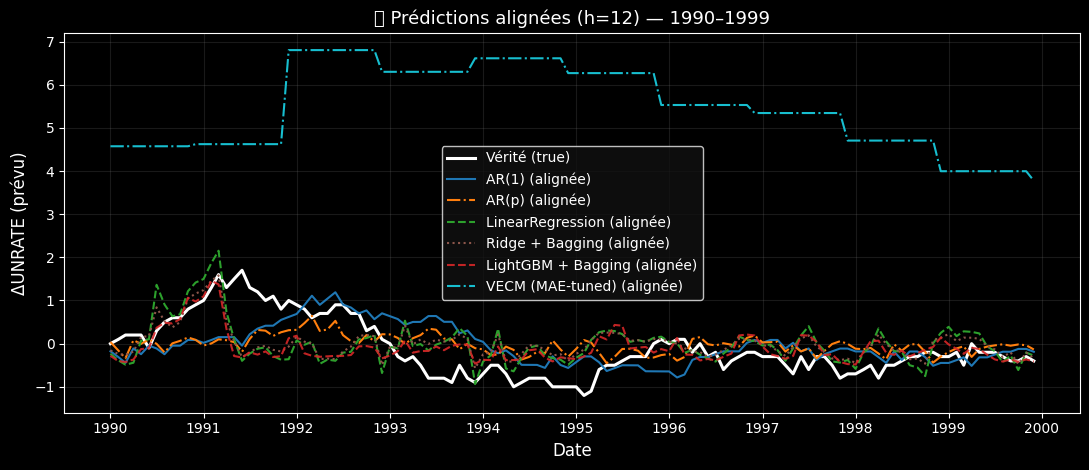

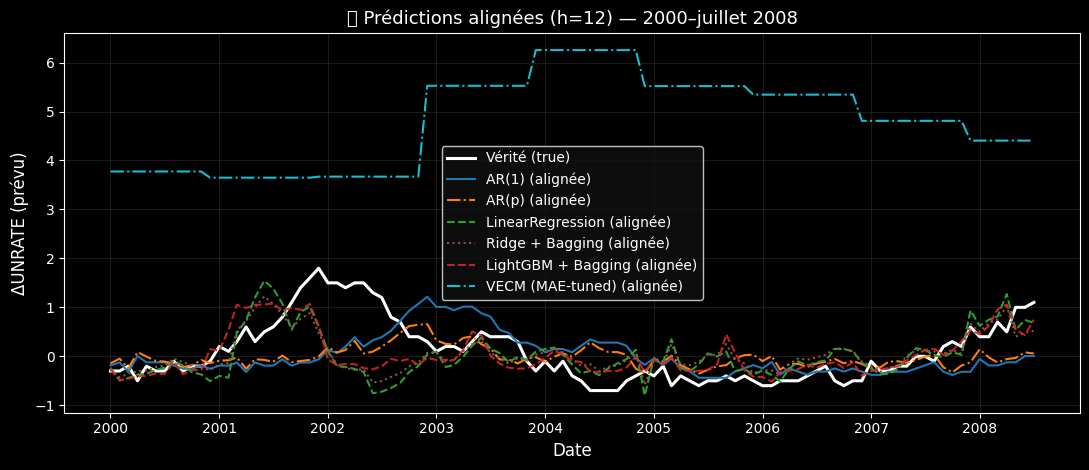

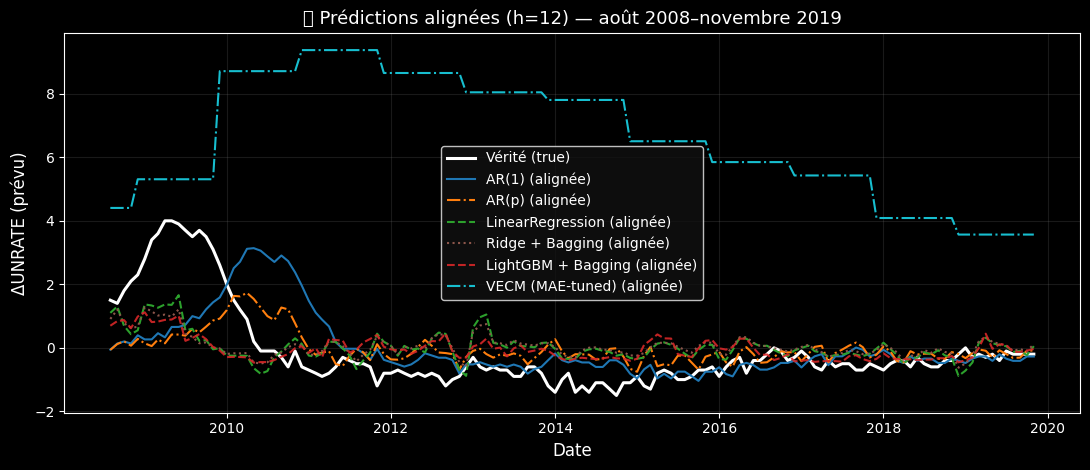

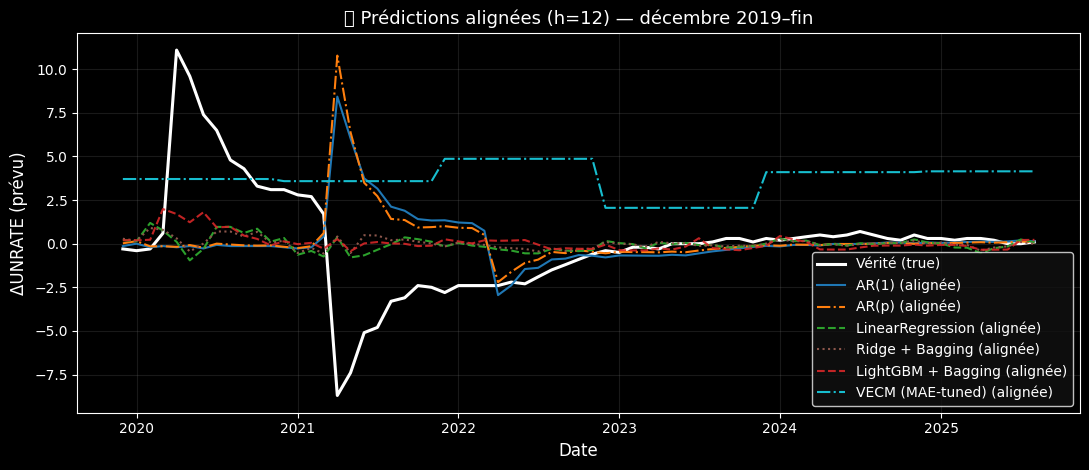

📁 Figures enregistrées (alignées) :
  - segment_aligne_1990_1999.png
  - segment_aligne_2000_juillet2008.png
  - segment_aligne_août2008_novembre2019.png
  - segment_aligne_decembre2019_fin.png


In [9]:
# ==========================================
# 🔹 Filtrage à partir de 1990
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df_pred_long doit déjà exister (fusion des bundles)
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"], errors="coerce")

# Garder uniquement les observations à partir de janvier 1990
df_pred_long = (
    df_pred_long[df_pred_long["date"] >= pd.Timestamp("1990-01-01")]
    .sort_values(["date", "method"])
    .reset_index(drop=True)
)

# ✅ Vérification
print(f"\n✅ Filtrage appliqué — période: {df_pred_long['date'].min().date()} → {df_pred_long['date'].max().date()} | n={len(df_pred_long)}")
print("Méthodes présentes :", sorted(df_pred_long['method'].unique().tolist()))

# Aperçu après filtrage
print("\nAperçu post-filtrage :")
print(df_pred_long.head(10))


# ==========================================
# 🔹 TEST global (plots par segments) — fond noir
# ==========================================

# ================== Style global (fond noir) ==================
plt.style.use("dark_background")
plt.rcParams.update({
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10
})

# ================== Paramètres ==================
H = 12  # horizon en mois (pour le mode "decale")

# ================== Sanity checks ==================
need_cols = {"date", "true", "pred", "method"}
missing = need_cols - set(df_pred_long.columns)
if missing:
    raise RuntimeError(f"df_pred_long doit contenir les colonnes {need_cols}. Manquantes: {missing}")

# ================== Pivot vers format large ==================
# - y_true unique par date (si plusieurs lignes : on prend la médiane)
true_by_date = (
    df_pred_long
    .assign(date=lambda d: pd.to_datetime(d["date"], errors="coerce"))
    .dropna(subset=["date"])
    .groupby("date", as_index=True)["true"]
    .median()
    .rename("true")
)

# - prédictions par méthode (moyenne si plusieurs lignes de la même méthode/date)
wide = (
    df_pred_long
    .assign(date=lambda d: pd.to_datetime(d["date"], errors="coerce"))
    .dropna(subset=["date"])
    .pivot_table(index="date", columns="method", values="pred", aggfunc="mean")
    .sort_index()
)

# - fusion de la vérité
wide = wide.join(true_by_date, how="left").sort_index()
if "true" not in wide.columns:
    raise RuntimeError("La colonne 'true' est absente après la fusion. Vérifie le contenu de df_pred_long.")

print("✅ wide prêt :", wide.shape, " | Colonnes :", wide.columns.tolist())

# ================== Détection colonnes disponibles ==================
has_ar1  = "AR(1)" in wide.columns

# AR(p) générique: 1re colonne qui ressemble à AR(...) mais ≠ AR(1)
arp_col  = next((c for c in wide.columns if isinstance(c, str) and c.startswith("AR(") and c != "AR(1)"), None)
has_arp  = arp_col is not None

has_lr   = "LinearRegression" in wide.columns

# Ridge: on accepte plusieurs libellés possibles
ridge_candidates = ["Ridge + Bagging", "Ridge+Bagging", "Ridge"]
ridge_col = next((c for c in ridge_candidates if c in wide.columns), None)
has_ridge = ridge_col is not None

# LightGBM: on accepte "LightGBM + Bagging", "LightGBM" ou "LGBMRegressor"
lgbm_candidates = ["LightGBM + Bagging", "LightGBM", "LGBMRegressor"]
lgbm_col = next((c for c in lgbm_candidates if c in wide.columns), None)
has_lgbm = lgbm_col is not None

# ✅ VECM: on accepte "VECM (MAE-tuned)" et "VECM"
vecm_candidates = ["VECM (MAE-tuned)", "VECM"]
vecm_col = next((c for c in vecm_candidates if c in wide.columns), None)
has_vecm = vecm_col is not None

# ================== Palette ==================
colors = {
    "true": "#ffffff",
    "AR(1)": "#1f77b4",
    "AR(p)": "#ff7f0e",
    "LinearRegression": "#2ca02c",
    "Ridge": "#9467bd",
    "Ridge + Bagging": "#8c564b",
    "Ridge+Bagging": "#8c564b",
    "LightGBM": "#d62728",
    "LightGBM + Bagging": "#d62728",
    "LGBMRegressor": "#d62728",
    "VECM": "#17becf",
    "VECM (MAE-tuned)": "#17becf",
}
if arp_col and arp_col not in colors:
    colors[arp_col] = colors["AR(p)"]
if ridge_col and ridge_col not in colors:
    colors[ridge_col] = colors["Ridge"]
if lgbm_col and lgbm_col not in colors:
    colors[lgbm_col] = colors["LightGBM"]
if vecm_col and vecm_col not in colors:
    colors[vecm_col] = colors["VECM"]

# ================== Fenêtres ==================
segments = [
    ("1990-01-01", "1999-12-31", "1990–1999"),
    ("2000-01-01", "2008-07-31", "2000–juillet 2008"),
    ("2008-08-01", "2019-11-30", "août 2008–novembre 2019"),
    ("2019-12-01", None,           "décembre 2019–fin"),
]

def _safe_color(key, default="#cccccc"):
    return colors.get(key, default)

def _file_suffix(label: str) -> str:
    return (
        label.lower()
             .replace("–", "_").replace("—", "_")
             .replace(" ", "")
             .replace("é", "e").replace("è", "e").replace("ê", "e").replace("à", "a")
    )

def plot_segment(wide_full: pd.DataFrame, start, end, title_suffix: str, mode: str = "aligne"):
    """
    mode = 'aligne'  : courbes alignées sur la vérité (mêmes dates que y_true)
         = 'decale'  : courbes décalées de H mois vers l'arrière (date de production)
         = 'erreur'  : courbes des |erreurs|
    """
    sub = wide_full.loc[start:end] if end else wide_full.loc[start:]
    if sub.empty:
        print(f"[!] Segment vide pour {title_suffix} — dates hors domaine.")
        return

    plt.figure(figsize=(11, 4.8))

    if mode == "aligne":
        plt.plot(sub.index, sub["true"], label="Vérité (true)", color=_safe_color("true"), linewidth=2.2)

        if has_ar1:
            plt.plot(sub.index, sub["AR(1)"], label="AR(1) (alignée)",
                     color=_safe_color("AR(1)"), linestyle='-')
        if has_arp:
            plt.plot(sub.index, sub[arp_col], label=f"{arp_col} (alignée)",
                     color=_safe_color(arp_col), linestyle='-.')
        if has_lr:
            plt.plot(sub.index, sub["LinearRegression"], label="LinearRegression (alignée)",
                     color=_safe_color("LinearRegression"), linestyle='--')
        if has_ridge:
            plt.plot(sub.index, sub[ridge_col], label=f"{ridge_col} (alignée)",
                     color=_safe_color(ridge_col), linestyle=':')
        if has_lgbm:
            plt.plot(sub.index, sub[lgbm_col], label=f"{lgbm_col} (alignée)",
                     color=_safe_color(lgbm_col), linestyle='--', alpha=0.9)
        if has_vecm:
            plt.plot(sub.index, sub[vecm_col], label=f"{vecm_col} (alignée)",
                     color=_safe_color(vecm_col), linestyle='-.')

        plt.title(f"🔹 Prédictions alignées (h={H}) — {title_suffix}")

    elif mode == "decale":
        idx_shift_sub = sub.index - pd.DateOffset(months=H)
        plt.plot(sub.index, sub["true"], label="Vérité (true)", color=_safe_color("true"), linewidth=2.2)

        if has_ar1:
            plt.plot(idx_shift_sub, sub["AR(1)"], label=f"AR(1) (faite {H} mois avant)",
                     color=_safe_color("AR(1)"), linestyle='-')
        if has_arp:
            plt.plot(idx_shift_sub, sub[arp_col], label=f"{arp_col} (faite {H} mois avant)",
                     color=_safe_color(arp_col), linestyle='-.')
        if has_lr:
            plt.plot(idx_shift_sub, sub["LinearRegression"], label=f"LinearRegression (faite {H} mois avant)",
                     color=_safe_color("LinearRegression"), linestyle='--')
        if has_ridge:
            plt.plot(idx_shift_sub, sub[ridge_col], label=f"{ridge_col} (faite {H} mois avant)",
                     color=_safe_color(ridge_col), linestyle=':')
        if has_lgbm:
            plt.plot(idx_shift_sub, sub[lgbm_col], label=f"{lgbm_col} (faite {H} mois avant)",
                     color=_safe_color(lgbm_col), linestyle='--', alpha=0.9)
        if has_vecm:
            plt.plot(idx_shift_sub, sub[vecm_col], label=f"{vecm_col} (faite {H} mois avant)",
                     color=_safe_color(vecm_col), linestyle='-.')

        plt.title(f"🔹 Prédictions décalées (h={H}) — {title_suffix}")

    elif mode == "erreur":
        if has_ar1:
            plt.plot(sub.index, np.abs(sub["true"] - sub["AR(1)"]),
                     label="|erreur| AR(1)", color=_safe_color("AR(1)"), linestyle='-')
        if has_arp:
            plt.plot(sub.index, np.abs(sub["true"] - sub[arp_col]),
                     label=f"|erreur| {arp_col}", color=_safe_color(arp_col), linestyle='-.')
        if has_lr:
            plt.plot(sub.index, np.abs(sub["true"] - sub["LinearRegression"]),
                     label="|erreur| LinearRegression", color=_safe_color("LinearRegression"), linestyle='--')
        if has_ridge:
            plt.plot(sub.index, np.abs(sub["true"] - sub[ridge_col]),
                     label=f"|erreur| {ridge_col}", color=_safe_color(ridge_col), linestyle=':')
        if has_lgbm:
            plt.plot(sub.index, np.abs(sub["true"] - sub[lgbm_col]),
                     label=f"|erreur| {lgbm_col}", color=_safe_color(lgbm_col), linestyle='--', alpha=0.9)
        if has_vecm:
            plt.plot(sub.index, np.abs(sub["true"] - sub[vecm_col]),
                     label=f"|erreur| {vecm_col}", color=_safe_color(vecm_col), linestyle='-.')

        plt.title(f"🔸 Erreurs absolues (h={H}) — {title_suffix}")
        plt.ylabel("|erreur|")

    plt.xlabel("Date")
    if mode != "erreur":
        plt.ylabel("ΔUNRATE (prévu)")

    # Légende lisible sur fond noir
    plt.legend(facecolor="#111", edgecolor="#EEE")
    plt.grid(alpha=0.2, color="gray")
    plt.tight_layout()

    # Nom de fichier propre
    suffix_file = _file_suffix(title_suffix)
    plt.savefig(f"segment_{mode}_{suffix_file}.png", dpi=150)
    plt.show()

# ================== 4 tracés alignés ==================
for start, end, label in segments:
    plot_segment(wide, start, end, label, mode="aligne")

print("📁 Figures enregistrées (alignées) :")
for _, _, label in segments:
    print(f"  - segment_aligne_{_file_suffix(label)}.png")

# 👉 Versions « décalées » :
# for start, end, label in segments:
#     plot_segment(wide, start, end, label, mode="decale")

# 👉 Versions « erreurs absolues » :
# for start, end, label in segments:
#     plot_segment(wide, start, end, label, mode="erreur")

In [11]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

# ========= utilitaires =========
def _get(meta, key, default=None):
    if meta is None:
        return default
    if isinstance(meta, dict):
        return meta.get(key, default)
    if isinstance(meta, pd.Series):
        return meta.get(key, default)
    if isinstance(meta, pd.DataFrame) and key in meta.columns:
        return meta[key].iloc[0]
    return default

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

# ========= AR générique -> DataFrame =========
def build_df_ar(ar_bundle=None, ar1_meta=None):
    # 1) Bundle dispo
    if ar_bundle is not None and isinstance(ar_bundle, dict) and "oos_predictions" in ar_bundle:
        df = ar_bundle["oos_predictions"].copy()
        if df.index.name is not None:
            df = df.reset_index()

        cols = {c.lower(): c for c in df.columns}
        date_col = cols.get("date") or cols.get("dates")
        true_col = cols.get("y_true") or cols.get("true")
        pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
        assert date_col and true_col and pred_col, f"Colonnes manquantes: {df.columns.tolist()}"

        out = df[[date_col, true_col, pred_col]].rename(columns={date_col:"date", true_col:"true", pred_col:"pred"})
        out["date"] = _normalize_month_start(out["date"])

        method_name = _get(ar_bundle.get("params", {}), "model", "AR")
        lag = _get(ar_bundle.get("params", {}), "lag", _get(ar_bundle.get("params", {}), "order_p", None))
        out["method"]      = method_name
        out["hyper_type"]  = _get(ar_bundle.get("params", {}), "hyper_type", "expanding_oos")
        out["features"]    = _get(ar_bundle, "features", 1)
        out["lag"]         = lag
        out["n_boot"]      = _get(ar_bundle.get("params", {}), "n_boot", None)
        out["winsorize"]   = _get(ar_bundle.get("params", {}), "winsor_level", None)
        out["window_size"] = _get(ar_bundle.get("params", {}), "window_size", None)

        out = out.reset_index(drop=True)
        print(f"✅ df_{method_name} prêt — from bundle — shape={out.shape}")
        return out

    # 2) Fallback calcul OOS si série univariée dispo
    eval_start = pd.to_datetime(_get(ar1_meta, "eval_start", "1983-01-01"))
    eval_end   = pd.to_datetime(_get(ar1_meta, "eval_end",   "1989-12-31"))
    h          = int(_get(ar1_meta, "horizon", 12))
    min_train_n= int(_get(ar1_meta, "min_train_n", 36))
    p_used     = int(_get(ar1_meta, "order_p", _get(ar1_meta, "p_used", 1)))

    if "df_stationary_train_unrate" in globals():
        from statsmodels.tsa.ar_model import AutoReg
        y = globals()["df_stationary_train_unrate"].squeeze().sort_index().astype(float).dropna()
        y.index = pd.to_datetime(y.index).to_period("M").to_timestamp(how="start")
        y = y.asfreq("MS")

        rows = []
        last_t_end = y.index.max() - relativedelta(months=h)
        for t_end in y.index:
            if t_end > last_t_end:
                break
            y_tr = y.loc[:t_end]
            if len(y_tr) < min_train_n:
                continue
            ar = AutoReg(y_tr, lags=p_used, old_names=False).fit()
            fc = ar.predict(start=len(y_tr), end=len(y_tr) + h - 1)
            yhat_h = float(fc.iloc[-1])
            t_fore = t_end + relativedelta(months=h)
            if t_fore in y.index:
                rows.append((t_fore, float(y.loc[t_fore]), yhat_h))

        out = pd.DataFrame(rows, columns=["date", "true", "pred"]).sort_values("date")
        out["date"] = _normalize_month_start(out["date"])
        out = out[(out["date"] >= eval_start) & (out["date"] <= eval_end)].copy()

        out["method"]      = f"AR({p_used})"
        out["hyper_type"]  = "expanding_oos"
        out["features"]    = 1
        out["lag"]         = p_used
        out["n_boot"]      = None
        out["winsorize"]   = None
        out["window_size"] = None

        out = out.reset_index(drop=True)
        print(f"✅ df_AR({p_used}) prêt — OOS h={h} (expanding) — shape={out.shape}")
        return out

    # 3) Rien
    raise RuntimeError(
        "Impossible de construire df_ar: fournis un bundle AR (AR1/ARP) ou 'df_stationary_train_unrate'."
    )

# ========= LinearRegression -> df_lin =========
def build_df_lin(linreg_bundle):
    if linreg_bundle is None or "oos_predictions" not in linreg_bundle:
        print("⚠️ linreg_bundle absent ou invalide.")
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = linreg_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans oos_predictions: {oos.columns.tolist()}"

    out = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    out["date"] = _normalize_month_start(out["date"])

    params = linreg_bundle.get("params", {}) or {}
    features = linreg_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    out["method"]      = params.get("model", "LinearRegression")
    out["hyper_type"]  = params.get("hyper_type", "kfold_block_gap")
    out["features"]    = features
    out["lag"]         = params.get("shift_lag", params.get("lag", None))
    out["n_boot"]      = params.get("n_boot", None)
    out["winsorize"]   = params.get("winsor_level", params.get("winsorize", None))
    out["window_size"] = params.get("window_size", None)

    out = out.reset_index(drop=True)
    print(f"✅ df_lin prêt — from oos_predictions — shape={out.shape}")
    return out

# ========= Ridge -> df_ridge =========
def build_df_ridge(ridge_bundle):
    if ridge_bundle is None or "oos_predictions" not in ridge_bundle:
        print("⚠️ ridge_bundle absent ou invalide.")
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = ridge_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans ridge oos_predictions: {oos.columns.tolist()}"

    out = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    out["date"] = _normalize_month_start(out["date"])

    params = ridge_bundle.get("params", {}) or {}
    features = ridge_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    out["method"]      = params.get("model", "Ridge")
    out["hyper_type"]  = params.get("alpha_schedule", "hv-block CV (gap=12)")
    out["features"]    = features
    out["lag"]         = params.get("lag", None)
    out["n_boot"]      = params.get("n_boot", None)
    out["winsorize"]   = params.get("winsor_level", None)
    out["window_size"] = params.get("window_size", None)

    out = out.reset_index(drop=True)
    print(f"✅ df_ridge prêt — from oos_predictions — shape={out.shape}")
    return out

# ========= LightGBM -> df_lgbm =========
def build_df_lgbm(lgbm_bundle):
    if lgbm_bundle is None or "oos_predictions" not in lgbm_bundle:
        print("⚠️ lgbm_bundle absent ou invalide.")
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = lgbm_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans lgbm oos_predictions: {oos.columns.tolist()}"

    out = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    out["date"] = _normalize_month_start(out["date"])

    params = lgbm_bundle.get("params", {}) or {}
    features = lgbm_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    out["method"]      = params.get("model", "LightGBM")
    out["hyper_type"]  = params.get("hyper_type", "kfold_block_gap + random search")
    out["features"]    = features
    out["lag"]         = params.get("lag", 12)
    out["n_boot"]      = params.get("n_boot", 30)
    out["winsorize"]   = params.get("winsor_level", None)
    out["window_size"] = params.get("window_size", None)

    out = out.reset_index(drop=True)
    print(f"✅ df_lgbm prêt — from oos_predictions — shape={out.shape}")
    return out

# ========= VECM -> df_vecm =========
def build_df_vecm(vecm_bundle):
    """
    Bundle VECM produit par notre script (VECM_BUNDLE):
      - 'oos_predictions': DataFrame avec colonnes ['date','y_pred','y_true'] (ou variantes)
      - 'params': dict avec 'model' etc.
    """
    if vecm_bundle is None or "oos_predictions" not in vecm_bundle:
        print("⚠️ vecm_bundle absent ou invalide.")
        return pd.DataFrame(columns=["date","true","pred","method"])

    oos = vecm_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and pred_col, f"Colonnes manquantes dans vecm oos_predictions: {oos.columns.tolist()}"

    # s'il n'y a pas y_true dans le bundle, on le met à NaN
    out = oos[[date_col, pred_col] + ([true_col] if true_col else [])].copy()
    out = out.rename(columns={date_col: "date", pred_col: "pred", (true_col or "y_true"): "true"})
    out["date"] = _normalize_month_start(out["date"])

    params = vecm_bundle.get("params", {}) or {}
    out["method"]      = params.get("model", "VECM")
    out["hyper_type"]  = "MAE rolling-origin (p, rank, det)"
    out["features"]    = len(params.get("features", [])) if isinstance(params.get("features", []), list) else None
    out["lag"]         = None
    out["n_boot"]      = None
    out["winsorize"]   = params.get("winsor_level", None)
    out["window_size"] = None

    out = out.reset_index(drop=True)
    print(f"✅ df_vecm prêt — from oos_predictions — shape={out.shape}")
    return out

# ======= Construction depuis les bundles chargés en amont =======
dfs = []

# AR(1)
if "ar1_bundle" in globals() and isinstance(ar1_bundle, dict):
    try:
        df_ar1 = build_df_ar(ar_bundle=ar1_bundle, ar1_meta=globals().get("ar1_meta", None))
        if not df_ar1.empty:
            dfs.append(df_ar1)
    except Exception as e:
        print(f"⚠️ build_df_ar (AR1) a échoué : {e}")

# AR(p)
if "arp_bundle" in globals() and isinstance(arp_bundle, dict):
    try:
        df_arp = build_df_ar(ar_bundle=arp_bundle, ar1_meta=globals().get("arp_meta", None))
        if not df_arp.empty:
            dfs.append(df_arp)
    except Exception as e:
        print(f"⚠️ build_df_ar (AR(p)) a échoué : {e}")

# LinearRegression
if "linreg_bundle" in globals() and isinstance(linreg_bundle, dict):
    try:
        df_lin = build_df_lin(linreg_bundle)
        if not df_lin.empty:
            dfs.append(df_lin)
    except Exception as e:
        print(f"⚠️ build_df_lin a échoué : {e}")

# Ridge
if "ridge_bundle" in globals() and isinstance(ridge_bundle, dict):
    try:
        df_ridge = build_df_ridge(ridge_bundle)
        if not df_ridge.empty:
            dfs.append(df_ridge)
    except Exception as e:
        print(f"⚠️ build_df_ridge a échoué : {e}")

# LightGBM
if "lgbm_bundle" in globals() and isinstance(lgbm_bundle, dict):
    try:
        df_lgbm = build_df_lgbm(lgbm_bundle)
        if not df_lgbm.empty:
            dfs.append(df_lgbm)
    except Exception as e:
        print(f"⚠️ build_df_lgbm a échoué : {e}")

# VECM
if "vecm_bundle" in globals() and isinstance(vecm_bundle, dict):
    try:
        df_vecm = build_df_vecm(vecm_bundle)
        if not df_vecm.empty:
            dfs.append(df_vecm)
    except Exception as e:
        print(f"⚠️ build_df_vecm a échoué : {e}")

# ======= Fusion finale =======
if len(dfs) == 0:
    raise RuntimeError("Aucun bundle exploitable (AR1, AR(p), LinearRegression, Ridge, LightGBM, VECM).")

df_pred_long = pd.concat(dfs, ignore_index=True)

# Nettoyage colonnes techniques (optionnel pour plotting simple)
cols_to_drop = ["hyper_type", "features", "lag", "n_boot", "winsorize", "window_size"]
df_pred_long = df_pred_long.drop(columns=[c for c in cols_to_drop if c in df_pred_long.columns], errors="ignore")

# Tri & index propre
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"], errors="coerce")
df_pred_long = df_pred_long.dropna(subset=["date", "true", "pred"]).sort_values(["date", "method"]).reset_index(drop=True)

print(f"\n✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
print("Colonnes :", df_pred_long.columns.tolist())
print("Méthodes :", sorted(df_pred_long["method"].unique().tolist()))

print("\nAperçu des premières lignes :")
print(df_pred_long.head(10))

✅ df_AR(1) prêt — from bundle — shape=(741, 10)
✅ df_AR(p) prêt — from bundle — shape=(741, 10)
✅ df_lin prêt — from oos_predictions — shape=(741, 10)
✅ df_ridge prêt — from oos_predictions — shape=(741, 10)
✅ df_lgbm prêt — from oos_predictions — shape=(741, 10)
✅ df_vecm prêt — from oos_predictions — shape=(729, 10)

✅ Fusion réussie — df_pred_long shape = (4434, 4)
Colonnes : ['date', 'true', 'pred', 'method']
Méthodes : ['AR(1)', 'AR(p)', 'LightGBM + Bagging', 'LinearRegression', 'Ridge + Bagging', 'VECM (MAE-tuned)']

Aperçu des premières lignes :
        date  true      pred              method
0 1963-12-01   0.0 -0.080890               AR(1)
1 1963-12-01   0.0 -0.080890               AR(p)
2 1963-12-01   0.0  0.097778  LightGBM + Bagging
3 1963-12-01   0.0 -0.354113    LinearRegression
4 1963-12-01   0.0 -0.254922     Ridge + Bagging
5 1964-01-01  -0.1  0.141077               AR(1)
6 1964-01-01  -0.1  0.141077               AR(p)
7 1964-01-01  -0.1  0.097778  LightGBM + Bagging


C:\Users\Mita\AppData\Local\Temp\ipykernel_13068\1706534752.py:313: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pred_long = pd.concat(dfs, ignore_index=True)


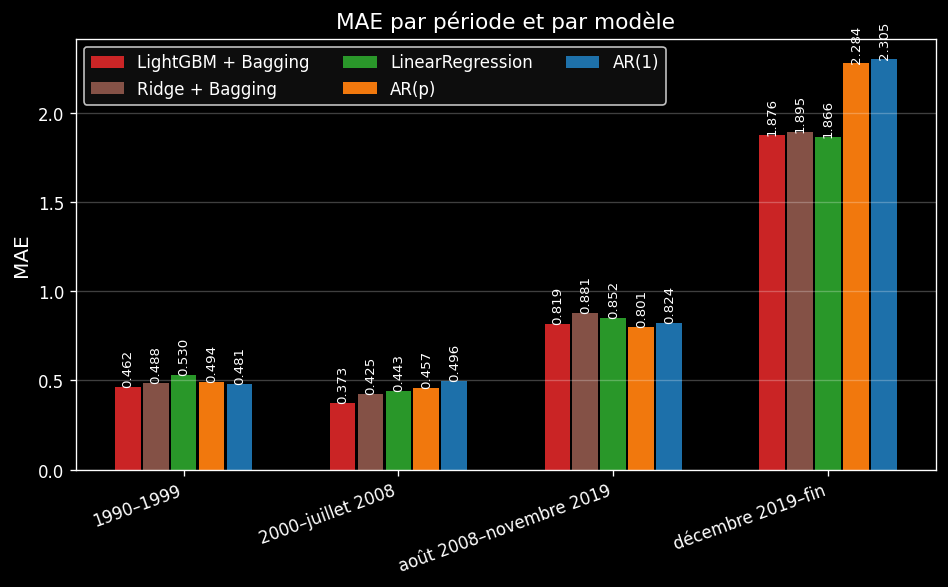

📁 Figure enregistrée → metrics_seg_MAE.png


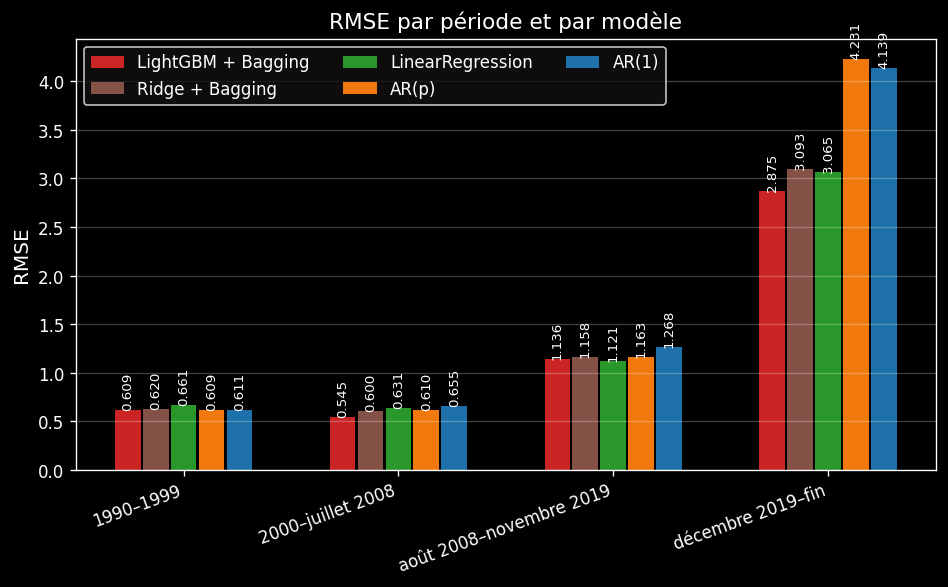

📁 Figure enregistrée → metrics_seg_RMSE.png


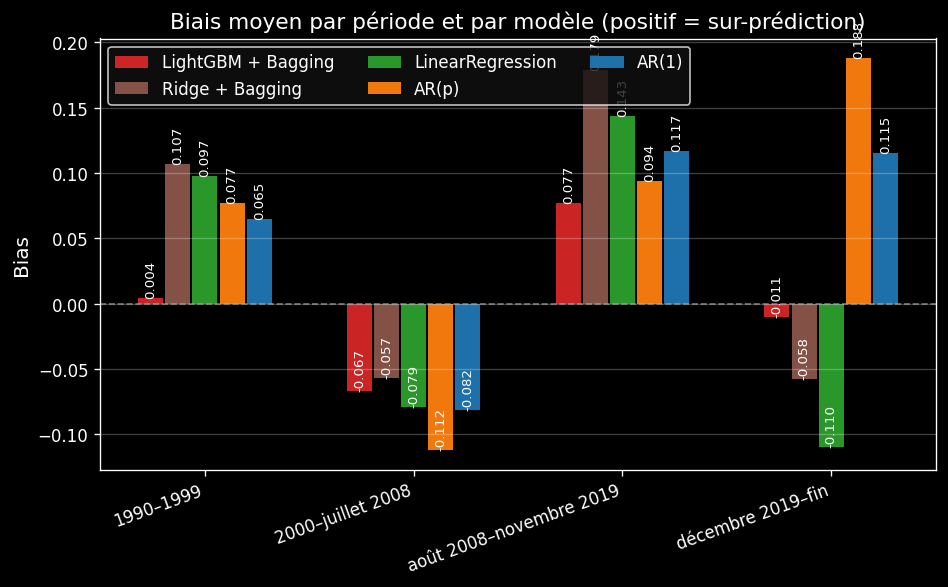

📁 Figure enregistrée → metrics_seg_Bias.png


# Test complet

In [21]:
# =========================================================
# Évaluation globale (1990 → fin) + DM tests (MSE & MAE)
# Requis: df_pred_long avec ['date','true','pred','method']
# Utilise les mêmes fonctions _metrics, _nw_var, dm_test que ton bloc
# =========================================================
import numpy as np
import pandas as pd
from itertools import combinations

# 1) Préparation
df_all = df_pred_long.copy()
df_all["date"] = pd.to_datetime(df_all["date"], errors="coerce")
df_all = df_all.dropna(subset=["date", "true", "pred", "method"]).sort_values(["date","method"]).reset_index(drop=True)

# 2) Métriques globales par modèle
def _metrics(y_true, y_pred):
    e = np.asarray(y_pred, float) - np.asarray(y_true, float)
    mae  = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e**2)))
    bias = float(np.mean(e))
    ssr  = float(np.sum(e**2))
    sst  = float(np.sum((np.asarray(y_true, float) - np.mean(y_true))**2))
    r2   = float(1 - ssr/sst) if sst > 0 else np.nan
    return pd.Series({"MAE": mae, "RMSE": rmse, "Bias": bias, "R2": r2})

metrics_global = (
    df_all.groupby("method")[["true","pred"]]
          .apply(lambda g: _metrics(g["true"], g["pred"]))
          .sort_values(["MAE","RMSE"])
          .reset_index()
)

print("\n=== 📊 Métriques globales (1990→fin) ===")
print(metrics_global)

# 3) DM global (sur l’ensemble 1990→fin)
H = 12  # ton horizon
def _nw_var(d, lag):
    d = np.asarray(d, float) - np.mean(d)
    T = len(d)
    if T <= 1: return np.nan
    var = np.dot(d,d)/T
    L = max(int(lag), 0)
    for l in range(1, L+1):
        cov = np.dot(d[l:], d[:-l]) / T
        var += 2 * (1 - l/(L+1)) * cov
    return var if (np.isfinite(var) and var > 1e-12) else 1e-12

from math import erf, sqrt
def dm_test(y, y1, y2, h=12, power=2, alternative="two_sided", hln_correction=True):
    y, y1, y2 = np.asarray(y,float), np.asarray(y1,float), np.asarray(y2,float)
    e1, e2 = y - y1, y - y2
    l1 = np.abs(e1) if power == 1 else e1**2
    l2 = np.abs(e2) if power == 1 else e2**2
    d = l1 - l2
    T = len(d)
    if T < 2: return np.nan, np.nan
    d_bar = float(np.mean(d))
    var_d = _nw_var(d, lag=max(h-1,0))
    if not np.isfinite(var_d) or var_d <= 0: return np.nan, np.nan
    DM = d_bar / np.sqrt(var_d / T)
    if hln_correction:
        k = (T + 1 - 2*h + h*(h - 1)/T) / T
        if np.isfinite(k) and k > 0: DM *= np.sqrt(k)
    cdf = lambda x: 0.5 * (1 + erf(x / sqrt(2)))
    if alternative == "two_sided":
        p = 2 * (1 - cdf(abs(DM)))
    elif alternative == "less":
        p = cdf(DM)
    else:
        p = 1 - cdf(DM)
    return float(DM), float(p)

# large: une colonne par méthode + true
base_true = df_all[["date","true"]].drop_duplicates("date").set_index("date").sort_index()
pred_wide = df_all.pivot(index="date", columns="method", values="pred").sort_index()
wide = pred_wide.join(base_true, how="inner").dropna(subset=["true"])

methods = sorted([c for c in pred_wide.columns if c in wide.columns])
rows_mse, rows_mae = [], []
for m1, m2 in combinations(methods, 2):
    sub = wide.dropna(subset=[m1, m2])
    n_use = len(sub)
    if n_use < 5:
        rows_mse.append({"m1": m1, "m2": m2, "n": n_use, "DM": np.nan, "pval": np.nan})
        rows_mae.append({"m1": m1, "m2": m2, "n": n_use, "DM": np.nan, "pval": np.nan})
        continue
    DM_mse, p_mse = dm_test(sub["true"], sub[m1], sub[m2], h=H, power=2)
    DM_mae, p_mae = dm_test(sub["true"], sub[m1], sub[m2], h=H, power=1)
    rows_mse.append({"m1": m1, "m2": m2, "n": n_use, "DM": DM_mse, "pval": p_mse})
    rows_mae.append({"m1": m1, "m2": m2, "n": n_use, "DM": DM_mae, "pval": p_mae})

df_dm_mse_global = pd.DataFrame(rows_mse).sort_values(["m1","m2"]).reset_index(drop=True)
df_dm_mae_global = pd.DataFrame(rows_mae).sort_values(["m1","m2"]).reset_index(drop=True)

print("\n=== ⚖️ DM global (MSE) — 1990→fin ===")
print(df_dm_mse_global)
print("\n=== ⚖️ DM global (MAE) — 1990→fin ===")
print(df_dm_mae_global)

# (optionnel) Sauvegardes
metrics_global.to_csv("metrics_global_1990_fin.csv", index=False)
df_dm_mse_global.to_csv("dm_mse_global_1990_fin.csv", index=False)
df_dm_mae_global.to_csv("dm_mae_global_1990_fin.csv", index=False)
print("\n📁 Fichiers écrits : metrics_global_1990_fin.csv, dm_mse_global_1990_fin.csv, dm_mae_global_1990_fin.csv")


=== 📊 Métriques globales (1990→fin) ===
               method       MAE      RMSE      Bias        R2
0  LightGBM + Bagging  0.781754  1.385199  0.007854  0.175562
1     Ridge + Bagging  0.824559  1.470659  0.063726  0.070697
2    LinearRegression  0.826731  1.460051  0.036055  0.084054
3               AR(p)  0.871151  1.873498  0.054779 -0.508135
4               AR(1)  0.887458  1.865704  0.054202 -0.495612

=== ⚖️ DM global (MSE) — 1990→fin ===
                   m1                  m2    n        DM      pval
0               AR(1)               AR(p)  428 -0.123426  0.901770
1               AR(1)  LightGBM + Bagging  428  1.355567  0.175237
2               AR(1)    LinearRegression  428  1.182856  0.236866
3               AR(1)     Ridge + Bagging  428  1.209269  0.226560
4               AR(p)  LightGBM + Bagging  428  1.226005  0.220197
5               AR(p)    LinearRegression  428  1.069732  0.284740
6               AR(p)     Ridge + Bagging  428  1.088940  0.276180
7  LightGBM 

✅ Synthèse :

Tous les modèles prévoient avec des erreurs du même ordre de grandeur.

L’ajout de complexité (AR(p) ou régression linéaire multivariée) n’apporte pas de gain significatif par rapport à AR(1).

Les différences observées (MAE, RMSE plus faibles pour la régression) ne sont pas statistiquement robustes.

⚙️ Implication pratique :

Pour un horizon de 12 mois, les dynamiques d’inertie contenues dans un simple AR(1) suffisent à capturer la tendance principale de ΔUNRATE.
Les modèles plus sophistiqués n’apportent pas de valeur ajoutée significative sur cet horizon.

Nous allons tester les 03 modèles dans le test